In [1]:
import pandas as pd
import numpy as np
from math import sqrt

# Visuals
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot

# T-test
from scipy.stats import anderson
from scipy import stats

# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc


data = pd.read_csv('Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv')

# RQ1: Year & Division VS. Police officer's workload/performance

In [2]:
# Year & Division Police officer's workload/performance table

# Data preprocessing
year_loc_officer_data = data.loc[:, ['Arrest_Year', 'ArrestLocDiv', 'PersonID']]
year_loc_officer_data

officer_table = year_loc_officer_data.groupby(['Arrest_Year', 'ArrestLocDiv', 'PersonID']).agg(
    Officer_Count = pd.NamedAgg(column = 'PersonID', aggfunc = 'count'))

officer_table

officer = officer_table.reset_index()

# print(officer)

year_officer = officer_table.reset_index().loc[:, ['Arrest_Year', 'PersonID', 'Officer_Count']]
year_officer
# unique_ID = year_loc_officer_table.reset_index()['PersonID'].unique()
# print(unique_ID)


arrest_year = [2020, 2021]*len(officer_table.reset_index()['PersonID'].unique())
officer_ID = np.repeat(officer_table.reset_index()['PersonID'].unique(), 2).tolist()
all_officer = pd.DataFrame(data = {'Arrest_Year': arrest_year, 'PersonID': officer_ID})
# print(new_officer.head())


year_officer_new = all_officer.merge(year_officer, on=['Arrest_Year', 'PersonID'], how='left').drop_duplicates(subset=['Arrest_Year', 'PersonID']).reset_index()

year_officer_new['Officer_Count'] = year_officer_new['Officer_Count'].fillna(0).astype('int')

# print(year_officer_new)


In [3]:
# Officer Descriptive Stats

import pandas as pd
import numpy as np
import math

# Year stats
year_stats = officer.groupby(['Arrest_Year']).Officer_Count.agg(['mean', 'count', 'std'])

year_ci95_hi = []
year_ci95_lo = []

for i in year_stats.index:
    m, c, s = year_stats.loc[i]
    year_ci95_lo.append(m - 1.96*s/math.sqrt(c))
    year_ci95_hi.append(m + 1.96*s/math.sqrt(c))

year_stats['ci95_lo'] = year_ci95_lo
year_stats['ci95_hi'] = year_ci95_hi
print(year_stats)



# Div stats
div_stats = officer.groupby(['ArrestLocDiv']).Officer_Count.agg(['mean', 'count', 'std'])

div_ci95_hi = []
div_ci95_lo = []

for i in div_stats.index:
    m, c, s = div_stats.loc[i]
    div_ci95_lo.append(m - 1.96*s/math.sqrt(c))
    div_ci95_hi.append(m + 1.96*s/math.sqrt(c))

div_stats['ci95_lo'] = div_ci95_lo
div_stats['ci95_hi'] = div_ci95_hi
print(div_stats)


                 mean  count       std   ci95_lo   ci95_hi
Arrest_Year                                               
2020         1.220852  26194  0.703666  1.212330  1.229374
2021         1.237209  26913  0.726025  1.228535  1.245883
                  mean  count       std   ci95_lo   ci95_hi
ArrestLocDiv                                               
11            1.188704   1505  0.619072  1.157427  1.219982
12            1.152727   1650  0.494673  1.128858  1.176596
13            1.177350    936  0.566969  1.141028  1.213673
14            1.240844   2512  0.696263  1.213616  1.268072
22            1.137062   1627  0.495015  1.113008  1.161116
23            1.117685   1555  0.443358  1.095648  1.139722
31            1.170455   1936  0.540719  1.146368  1.194541
32            1.141607   1829  0.486314  1.119320  1.163895
33            1.068233    894  0.318939  1.047326  1.089140
41            1.157387   2281  0.493154  1.137149  1.177626
42            1.132515   1630  0.468385  1.1

In [4]:
# Check 4 assumption for T-test

Year_Loc_Officer_Count_2020 = year_officer_new.loc[year_officer_new['Arrest_Year'] == 2020].loc[:,'Officer_Count']
Year_Loc_Officer_Count_2021 = year_officer_new.loc[year_officer_new['Arrest_Year'] == 2021].loc[:,'Officer_Count']


# Check Normality(Anderson-Darling Nonrmality Test)
res_2020 = anderson(Year_Loc_Officer_Count_2020)
res_2021 = anderson(Year_Loc_Officer_Count_2021)

print(res_2020.statistic)
print(res_2020.critical_values)
print(res_2020.significance_level)

print(res_2021.statistic)
print(res_2021.critical_values)
print(res_2021.significance_level)

# Check homogeneity of variance
print(np.var(Year_Loc_Officer_Count_2020),np.var(Year_Loc_Officer_Count_2021))
np.var(Year_Loc_Officer_Count_2021)/np.var(Year_Loc_Officer_Count_2021) <= 4


3928.2563927691226
[0.576 0.656 0.787 0.918 1.092]
[15.  10.   5.   2.5  1. ]
3888.4771799450464
[0.576 0.656 0.787 0.918 1.092]
[15.  10.   5.   2.5  1. ]
0.4762954701649649 0.47612920241006673


True

The test statistic is 13515. We can compare this value to each critical value that corresponds to each significance level to see if the test result are significant.
\
The critical value for alpha = 0.1 is 1.092. Test result is greater than this critical value, so significant at this level.
\
We can see the test result is significant at every significance level, which means we can reject the null hypothesis. Thus we have sufficient evidence to say that the sample data is not normally distributed.
\
Population variances are equal.

In [5]:
# paired T-test

# want to check whether officers have the same mean number of case managed for 2020 and 2021
# Ha: population1 mean is not equal to population2 mean

# perform the paired t-test
stats.ttest_rel(a = Year_Loc_Officer_Count_2021, b = Year_Loc_Officer_Count_2020)


TtestResult(statistic=3.278615283965454, pvalue=0.001044130843097159, df=37346)

T-test Result (statistic=3.278615283965454, pvalue=0.001044130843097159, df=37346)
\
Since P-value(0.001 is smaller than alpha = 0.05, so we reject the null hypothesis of the test. We have sufficient evidence to say two group means are not equal. 

In [6]:
# perform two-way ANOVA

# Get the data
year_loc_officer_table = year_loc_officer_data.groupby(['Arrest_Year', 'ArrestLocDiv', 'PersonID']).agg(
    Year_Loc_Officer_Count = pd.NamedAgg(column = 'PersonID', aggfunc = 'count'))

year_loc_officer = year_loc_officer_table.reset_index().loc[:, ['Arrest_Year', 'ArrestLocDiv', 'Year_Loc_Officer_Count']]

officer_interactive_model = ols('Year_Loc_Officer_Count ~ C(Arrest_Year) + C(ArrestLocDiv) + C(Arrest_Year):C(ArrestLocDiv)', data = year_loc_officer).fit()
officer_interactive_table = sm.stats.anova_lm(officer_interactive_model, typ = 2)
officer_interactive_table

,sum_sq,df,F,PR(>F)
C(Arrest_Year),3.187982,1.0,6.306177,1.203475e-02
C(ArrestLocDiv),313.828527,17.0,36.516890,3.129573e-120
C(Arrest_Year):C(ArrestLocDiv),12.046501,17.0,1.401723,1.242035e-01
Residual,26829.154677,53071.0,NaN,NaN


Both year and div are statistically significant. 
\
The p-val of the interation term is greater than alpha = 0.05, we fail to reject the null hypothesis at this level of significance.

In [7]:
# Re-run the two-way ANOVA without the interaction term

officer_additive_model = ols('Year_Loc_Officer_Count ~ C(Arrest_Year) + C(ArrestLocDiv)', data = year_loc_officer).fit()
officer_additive_table = sm.stats.anova_lm(officer_additive_model, typ = 2)
print(officer_additive_table)

officer_residual_sd = math.sqrt(officer_additive_table['sum_sq'][2]/officer_additive_table['df'][2])
officer_residual_sd

                       sum_sq       df          F         PR(>F)
C(Arrest_Year)       3.187982      1.0   6.305366   1.204025e-02
C(ArrestLocDiv)    313.828527     17.0  36.512193  3.250680e-120
Residual         26841.201178  53088.0        NaN            NaN


0.7110543397976259

In [8]:
# Tukey's HSD Test

# Difference across division groups
officer_comp = mc.MultiComparison(year_loc_officer['Year_Loc_Officer_Count'], year_loc_officer['ArrestLocDiv'])
officer_div_post_hoc_res = officer_comp.tukeyhsd()
officer_div_post_hoc_res.summary()

# Extract different levels
officer_div_post_hoc_res_summary = pd.DataFrame(officer_div_post_hoc_res.summary())
officer_div_post_hoc_res_summary.columns = ['Group1','Group2', 'MeanDiff', 'p-adj', '4', '5', 'Reject']
officer_div_post_hoc_res_summary['Reject'] =  officer_div_post_hoc_res_summary['Reject'].astype('str')
officer_div_post_hoc_res_summary
officer_differences = officer_div_post_hoc_res_summary.loc[officer_div_post_hoc_res_summary['Reject'] == 'True', ['Group1','Group2', 'MeanDiff', 'p-adj', 'Reject']]
print(officer_differences)
print('Difference exist in the ', len(officer_differences), ' out of ', len(officer_div_post_hoc_res_summary) - 1, ' comparisons.')
# len(search_differences)
# len(search_race_post_hoc_res_summary)

    Group1 Group2 MeanDiff   p-adj Reject
8       11     33  -0.1205  0.0076   True
12      11     51   0.2181     0.0   True
17      11     XX   0.0862  0.0007   True
19      12     14   0.0881  0.0113   True
28      12     51    0.254     0.0   True
33      12     XX   0.1222     0.0   True
43      13     51   0.2294     0.0   True
48      13     XX   0.0975   0.005   True
49      14     22  -0.1038  0.0006   True
50      14     23  -0.1232     0.0   True
52      14     32  -0.0992  0.0008   True
53      14     33  -0.1726     0.0   True
54      14     41  -0.0835  0.0063   True
55      14     42  -0.1083  0.0002   True
57      14     51   0.1659     0.0   True
58      14     52  -0.0955  0.0009   True
59      14     53   -0.113  0.0007   True
70      22     51   0.2697     0.0   True
73      22     54   0.1017  0.0226   True
75      22     XX   0.1378     0.0   True
82      23     51   0.2891     0.0   True
85      23     54   0.1211  0.0016   True
87      23     XX   0.1572     0.0

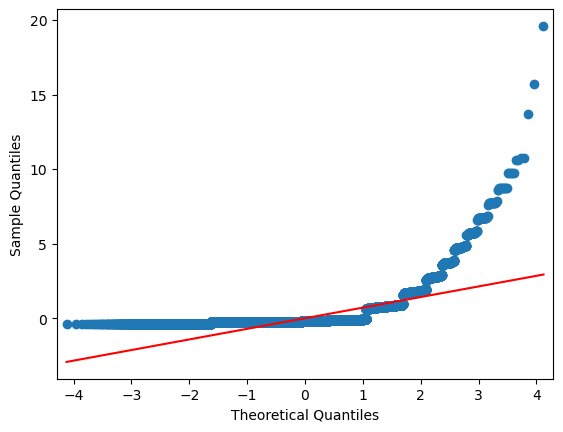

In [9]:
# check ANOVA assumptions
# QQ-plot(normality)
res_q1 = officer_additive_model.resid
fig = sm.qqplot(res_q1, line = 's')
plt.show()

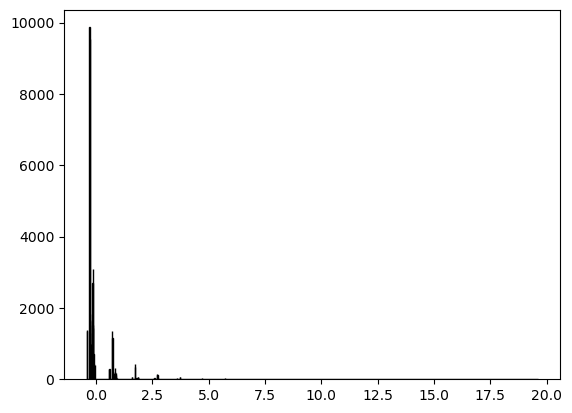

In [10]:
plt.hist(res_q1, bins = 'auto', histtype = 'bar', ec = 'k')
plt.xlabel = ('Residual')
plt.ylabel = ('Frequency')
plt.show()

Since dataset is not normal, so we decide to apply Levene's test (division)

In [11]:
# homogeneity of variance
# H0: samples(division) from populations have equal variance
stats.levene(year_loc_officer[year_loc_officer['ArrestLocDiv'] == '11'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '12'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '13'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '14'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '22'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '23'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '31'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '32'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '33'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '41'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '42'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '43'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '51'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '52'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '53'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '54'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == '55'].loc[:,'Year_Loc_Officer_Count'],
             year_loc_officer[year_loc_officer['ArrestLocDiv'] == 'XX'].loc[:,'Year_Loc_Officer_Count'])

LeveneResult(statistic=36.55082442270388, pvalue=2.3680631312503367e-120)

Levene Result (statistic=36.55082442270388, pvalue=2.3680631312503367e-120)
\
Have sufficient evidence to reject null hypothesis that samples have equal variance.
\
Equal variance assumption for division is violated.

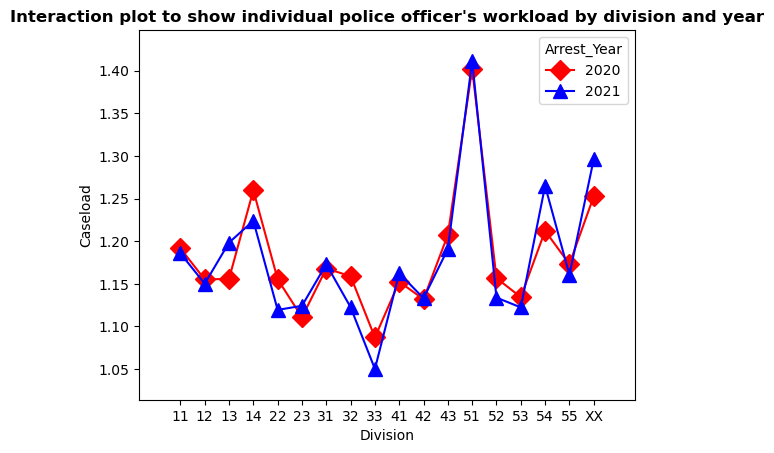

In [12]:
# Interaction plot

from importlib import reload
plt=reload(plt)

Arrest_Year = year_loc_officer['Arrest_Year'].astype("category")
Year_Loc_Officer_Count = year_loc_officer['Year_Loc_Officer_Count'].values


rq_1_interaction = interaction_plot(year_loc_officer['ArrestLocDiv'], Arrest_Year, Year_Loc_Officer_Count, colors=['red','blue'], markers=['D','^'], ms=10)

plt.ylabel('Caseload')
plt.xlabel('Division')
plt.title('Interaction plot to show individual police officer\'s workload by division and year', fontweight='bold')
plt.show()

# RQ2: Search Reason & Race Vs. #ofStripSearch 

In [13]:
# Search Reason & Race Vs. #ofStripSearch table


# Data preprocessing
# 0 - Year, 1 - Month, 5 - Perceived_Race
# 19 - SearchReason_CauseInjury, 20 - SearchReason_AssistEscape, 21 - SearchReason_PossessWeapons, 22 - SearchReason_PossessEvidence
search =  data.loc[data.StripSearch == 1].iloc[:, [0, 1, 5, 19, 20, 21, 22]]
search.columns = ['Year', 'Month', 'Race','CauseInjury', 'AssistEscape', 'PossessWeapons', 'PossessEvidence']
# search
search_new_idx = search.astype({'CauseInjury':'int', 'AssistEscape':'int', 'PossessWeapons':'int', 'PossessEvidence':'int'}).set_index(['Race', 'Year', 'Month'])
# search_new_idx

search_stack = search_new_idx.stack(0)
search_stack = search_stack.reset_index()
# search_stack
search_stack.columns = ['Race', 'Year', 'Month', 'SearchReason', 'Searched']

search_stack_data = search_stack.loc[search_stack.Searched == 1]
# search_stack_data

search_race_table = search_stack_data.groupby(['Race', 'Year', 'Month', 'SearchReason']).agg(
    Search_Count = pd.NamedAgg(column = 'Searched', aggfunc = 'count'))
# search_race_table

# get the data
search_race = search_race_table.reset_index().loc[:, ['Race', 'SearchReason', 'Search_Count']]
search_race

,Race,SearchReason,Search_Count
0,Black,AssistEscape,211
1,Black,CauseInjury,399
2,Black,PossessEvidence,252
3,Black,PossessWeapons,284
4,Black,AssistEscape,357
...,...,...,...
219,White,PossessWeapons,17
220,White,AssistEscape,2
221,White,CauseInjury,29
222,White,PossessEvidence,31


In [14]:
# Search Descriptive Stats

# search_race

import pandas as pd
import numpy as np
import math

# Race stats
race_stats = search_race.groupby(['Race']).Search_Count.agg(['mean', 'count', 'std'])

race_ci95_hi = []
race_ci95_lo = []

for i in race_stats.index:
    m, c, s = race_stats.loc[i]
    race_ci95_lo.append(m - 1.96*s/math.sqrt(c))
    race_ci95_hi.append(m + 1.96*s/math.sqrt(c))

race_stats['ci95_lo'] = race_ci95_lo
race_stats['ci95_hi'] = race_ci95_hi
print(race_stats)



# Search reason stats
reason_stats = search_race.groupby(['SearchReason']).Search_Count.agg(['mean', 'count', 'std'])

reason_ci95_hi = []
reason_ci95_lo = []

for i in reason_stats.index:
    m, c, s = reason_stats.loc[i]
    reason_ci95_lo.append(m - 1.96*s/math.sqrt(c))
    reason_ci95_hi.append(m + 1.96*s/math.sqrt(c))

reason_stats['ci95_lo'] = reason_ci95_lo
reason_stats['ci95_hi'] = reason_ci95_hi
print(reason_stats)


                            mean  count         std     ci95_lo     ci95_hi
Race                                                                       
Black                 159.322581     31  187.947047   93.160260  225.484901
East/Southeast Asian   22.000000     29   24.124676   13.219514   30.780486
Indigenous             22.962963     27   25.069874   13.506552   32.419374
Latino                 12.217391     23   11.700647    7.435474   16.999308
Middle-Eastern         15.379310     29   18.162783    8.768732   21.989889
South Asian            20.875000     24   22.158152   12.009893   29.740107
Unknown or Legacy      35.172414     29   41.617363   20.025239   50.319588
White                 218.968750     32  276.739715  123.083331  314.854169
                      mean  count         std    ci95_lo     ci95_hi
SearchReason                                                        
AssistEscape     60.818182     44  119.686854  25.452977   96.183387
CauseInjury      99.533333     60

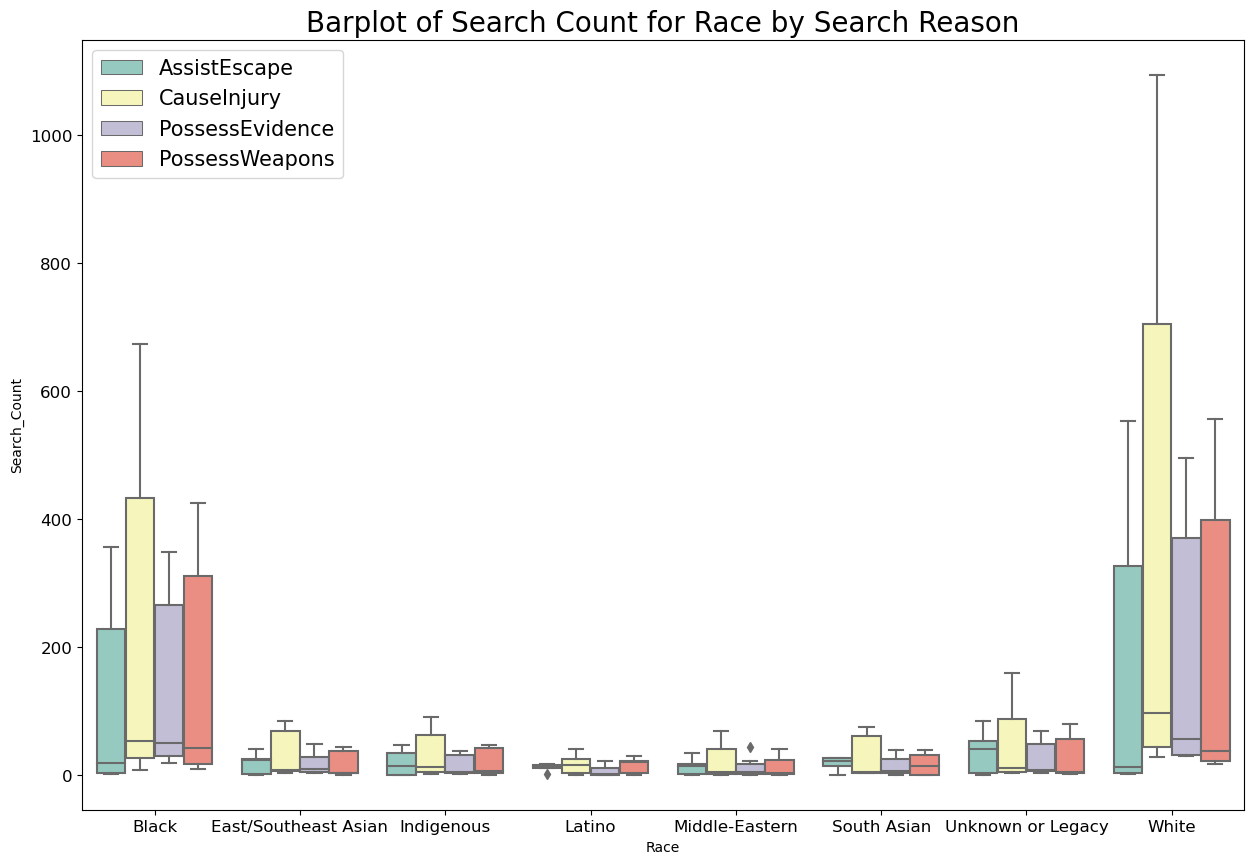

In [15]:
# Boxplot to see the distribution by race and search reason
fig,ax = plt.subplots(figsize=(15,10))
sns.boxplot(x = 'Race', y = 'Search_Count', hue = 'SearchReason', data = search_race, palette = 'Set3')
plt.title('Barplot of Search Count for Race by Search Reason', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize = 15)

In [16]:
# Check 4 assumption

search_race_norm = search_race.loc[:,'Search_Count']

# Check Normality(Anderson-Darling Nonrmality Test)
res = anderson(search_race_norm)
print(res.statistic)
print(res.critical_values)
print(res.significance_level)

43.90489813490444
[0.566 0.645 0.774 0.902 1.073]
[15.  10.   5.   2.5  1. ]


The test statistic is 43.905. We can compare this value to each critical value that corresponds to each significance level to see if the test result are significant.
\
The critical value for alpha = 0.1 is 1.073. Test result is greater than this critical value, so significant at this level.
\
We can see the test result is significant at every significance level, which means we can reject the null hypothesis. Thus we have sufficient evidence to say that the sample data is not normally distributed.


In [17]:
# Perform two-way ANOVA
search_interactive_model = ols('Search_Count ~ C(Race) + C(SearchReason) + C(Race):C(SearchReason)', data = search_race).fit()
search_interactive_table = sm.stats.anova_lm(search_interactive_model, typ = 2)
search_interactive_table

,sum_sq,df,F,PR(>F)
C(Race),1.354282e+06,7.0,11.286626,5.937831e-12
C(SearchReason),9.316626e+04,3.0,1.811717,1.464011e-01
C(Race):C(SearchReason),1.542077e+05,21.0,0.428391,9.873658e-01
Residual,3.291154e+06,192.0,NaN,NaN


Race effect is statistically significant, while search reason effect is not statistically significant.
\
The p-val of the interation term is greater than alpha = 0.05, we fail to reject the null hypothesis at this level of significance.

In [18]:
# Re-run the two-way ANOVA without the interaction term
search_additive_model = ols('Search_Count ~ C(Race) + C(SearchReason)', data = search_race).fit()
search_additive_table = sm.stats.anova_lm(search_additive_model, typ = 2)
print(search_additive_table)

search_residual_sd = sqrt(search_additive_table['sum_sq'][2]/search_additive_table['df'][2])
search_residual_sd

                       sum_sq     df          F        PR(>F)
C(Race)          1.354282e+06    7.0  11.960681  7.643598e-13
C(SearchReason)  9.316626e+04    3.0   1.919916  1.273450e-01
Residual         3.445362e+06  213.0        NaN           NaN


127.18257831460315

In [19]:
# Tukey's HSD Test

# Difference across race groups
search_comp = mc.MultiComparison(search_race['Search_Count'], search_race['Race'])
search_race_post_hoc_res = search_comp.tukeyhsd()
search_race_post_hoc_res.summary()

# Extract different levels
search_race_post_hoc_res_summary = pd.DataFrame(search_race_post_hoc_res.summary())
search_race_post_hoc_res_summary.columns = ['Group1','Group2', 'MeanDiff', 'p-adj', '4', '5', 'Reject']
search_race_post_hoc_res_summary['Reject'] =  search_race_post_hoc_res_summary['Reject'].astype('str')
search_race_post_hoc_res_summary
search_differences = search_race_post_hoc_res_summary.loc[search_race_post_hoc_res_summary['Reject'] == 'True', ['Group1','Group2', 'MeanDiff', 'p-adj', 'Reject']]
print(search_differences)
print('Difference exist in the ', len(search_differences), ' out of ', len(search_race_post_hoc_res_summary) - 1, ' comparisons.')
# len(search_differences)
# len(search_race_post_hoc_res_summary)

                  Group1                Group2   MeanDiff   p-adj Reject
1                  Black  East/Southeast Asian  -137.3226  0.0012   True
2                  Black            Indigenous  -136.3596  0.0018   True
3                  Black                Latino  -147.1052  0.0011   True
4                  Black        Middle-Eastern  -143.9433  0.0005   True
5                  Black           South Asian  -138.4476  0.0024   True
6                  Black     Unknown or Legacy  -124.1502  0.0054   True
13  East/Southeast Asian                 White   196.9688     0.0   True
18            Indigenous                 White   196.0058     0.0   True
22                Latino                 White   206.7514     0.0   True
25        Middle-Eastern                 White   203.5894     0.0   True
27           South Asian                 White   198.0938     0.0   True
28     Unknown or Legacy                 White   183.7963     0.0   True
Difference exist in the  12  out of  28  comparison

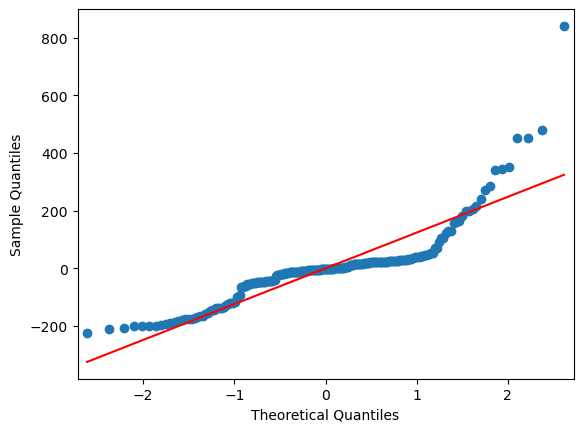

In [20]:
# check ANOVA assumptions
# QQ-plot(normality)
res_q2 = search_additive_model.resid
fig = sm.qqplot(res_q2, line = 's')
plt.show()

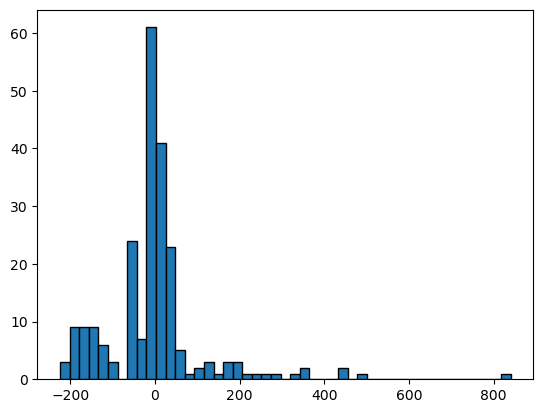

In [21]:
plt.hist(res_q2, bins = 'auto', histtype = 'bar', ec = 'k')
plt.xlabel = ('Residual')
plt.ylabel = ('Frequency')
plt.show()

Since dataset is not normal, so we decide to apply Levene's test (race)

In [22]:
# homogeneity of variance
# H0: samples(race) from populations have equal variance
stats.levene(search_race[search_race['Race'] == 'Black'].loc[:,'Search_Count'], 
             search_race[search_race['Race'] == 'East/Southeast Asian'].loc[:,'Search_Count'],
             search_race[search_race['Race'] == 'Indigenous'].loc[:,'Search_Count'],
             search_race[search_race['Race'] == 'Latino'].loc[:,'Search_Count'],
             search_race[search_race['Race'] == 'Middle-Eastern'].loc[:,'Search_Count'],
             search_race[search_race['Race'] == 'South Asian'].loc[:,'Search_Count'],
             search_race[search_race['Race'] == 'Unknown or Legacy'].loc[:,'Search_Count'],
             search_race[search_race['Race'] == 'White'].loc[:,'Search_Count'])

LeveneResult(statistic=10.99809548723979, pvalue=7.208941029886825e-12)

LeveneResult (statistic=10.99809548723979, pvalue=7.208941029886825e-12)
\
Have sufficient evidence to reject null hypothesis that samples have equal variance.
\
Equal variance assumption for race is violated.

In [23]:
# H0: samples(sesarch reason) from populations have equal variance
stats.levene(search_race[search_race['SearchReason'] == 'AssistEscape'].loc[:,'Search_Count'], 
             search_race[search_race['SearchReason'] == 'CauseInjury'].loc[:,'Search_Count'],
             search_race[search_race['SearchReason'] == 'PossessEvidence'].loc[:,'Search_Count'],
             search_race[search_race['SearchReason'] == 'PossessWeapons'].loc[:,'Search_Count'])

LeveneResult(statistic=1.195432573076061, pvalue=0.31237347826784817)

LeveneResult (statistic=1.195432573076061, pvalue=0.31237347826784817)
\
Fail to reject null hypothesis.
\
Equal variance assumption for search reason is checked.

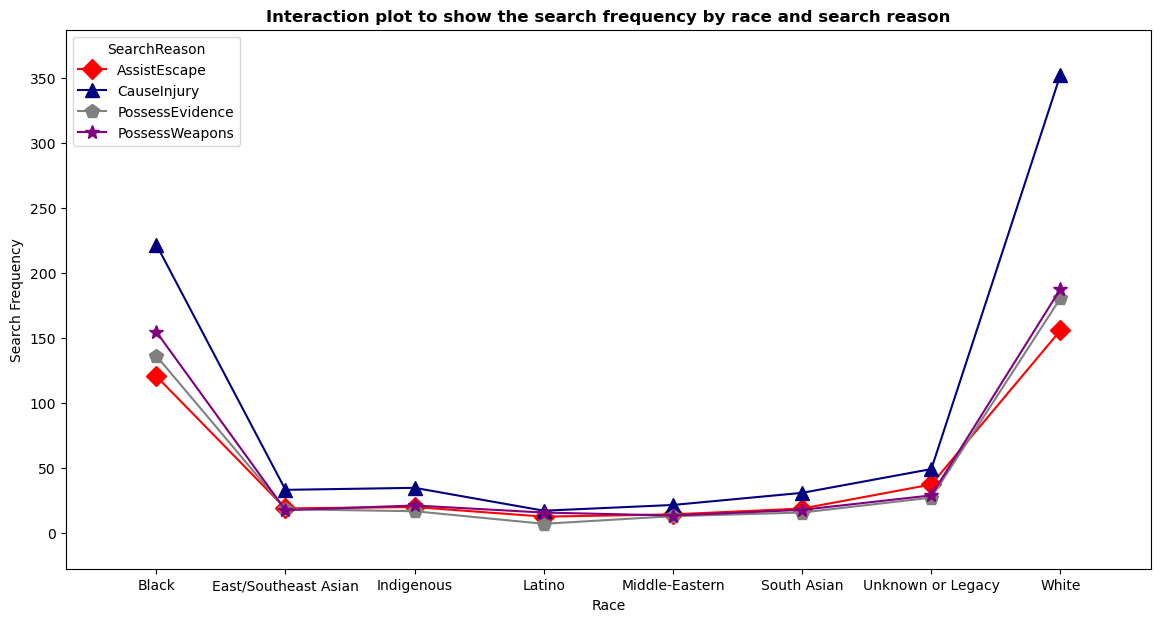

In [24]:
# Interaction plot 
from importlib import reload
plt=reload(plt)

SearchReason = search_race['SearchReason'].astype("category")
Search_Count = search_race['Search_Count'].values

plt.rcParams["figure.figsize"] = [14,7]
rq_2_interaction = interaction_plot(search_race['Race'], SearchReason, Search_Count, colors=['red','navy', 'gray', 'purple'], markers=['D','^', 'p', '*'], ms=10)

plt.ylabel('Search Frequency')
plt.xlabel('Race')
plt.title('Interaction plot to show the search frequency by race and search reason', fontweight='bold')
plt.show()


# RQ3: Age group & Sex Vs. #ofNon-cooperative

In [25]:
# Age group & Sex Vs. #ofNon-cooperative table

# Data preprocessing
# Non-cooperative data
noncoop_data = data.loc[(data.Actions_at_arrest___Cooperative == 0) & (data.Sex != 'U')].loc[:, ['Sex', 'Perceived_Race', 'Age_group__at_arrest_']]
# print(noncoop_data)

# Non-cooperative count table aggregated by race and age
noncoop_table = noncoop_data.groupby(['Sex', 'Perceived_Race', 'Age_group__at_arrest_']).agg(
   NonCoop_Count=pd.NamedAgg(column="Age_group__at_arrest_", aggfunc="count"))
# print(noncoop_table)

# Get the sub-dataset
noncoop = noncoop_table.reset_index().loc[:, ['Sex', 'Age_group__at_arrest_', 'NonCoop_Count']]
# print(noncoop['Age_group__at_arrest_'].unique())

noncoop.loc[noncoop.Age_group__at_arrest_ == 'Aged 17 years and under', 'Age_group__at_arrest_'] = 'Aged 17 years and younger'
noncoop.loc[noncoop.Age_group__at_arrest_ == 'Aged 65 and older', 'Age_group__at_arrest_']= 'Aged 65 years and older'
noncoop
print(noncoop['Age_group__at_arrest_'].unique())

['Aged 17 years and younger' 'Aged 18 to 24 years' 'Aged 25 to 34 years'
 'Aged 35 to 44 years' 'Aged 45 to 54 years' 'Aged 55 to 64 years'
 'Aged 65 years and older']


In [26]:
# Non-coop Descriptive Stats

import pandas as pd
import numpy as np
import math

# Age stats
age_stats = noncoop.groupby(['Age_group__at_arrest_']).NonCoop_Count.agg(['mean', 'count', 'std'])

age_ci95_hi = []
age_ci95_lo = []

for i in age_stats.index:
    m, c, s = age_stats.loc[i]
    age_ci95_lo.append(m - 1.96*s/math.sqrt(c))
    age_ci95_hi.append(m + 1.96*s/math.sqrt(c))

age_stats['ci95_lo'] = age_ci95_lo
age_stats['ci95_hi'] = age_ci95_hi
print(age_stats)



# Sex stats
sex_stats = noncoop.groupby(['Sex']).NonCoop_Count.agg(['mean', 'count', 'std'])

sex_ci95_hi = []
sex_ci95_lo = []

for i in sex_stats.index:
    m, c, s = sex_stats.loc[i]
    sex_ci95_lo.append(m - 1.96*s/math.sqrt(c))
    sex_ci95_hi.append(m + 1.96*s/math.sqrt(c))

sex_stats['ci95_lo'] = sex_ci95_lo
sex_stats['ci95_hi'] = sex_ci95_hi
print(sex_stats)

                                 mean  count          std     ci95_lo  \
Age_group__at_arrest_                                                   
Aged 17 years and younger   50.812500     32    74.721607   24.922784   
Aged 18 to 24 years        351.250000     16   457.525737  127.062389   
Aged 25 to 34 years        738.312500     16  1046.426727  225.563404   
Aged 35 to 44 years        564.062500     16   876.379177  134.636703   
Aged 45 to 54 years        305.000000     16   511.947914   54.145522   
Aged 55 to 64 years        156.250000     16   290.649961   13.831519   
Aged 65 years and older     24.178571     28    39.164471    9.671848   

                               ci95_hi  
Age_group__at_arrest_                   
Aged 17 years and younger    76.702216  
Aged 18 to 24 years         575.437611  
Aged 25 to 34 years        1251.061596  
Aged 35 to 44 years         993.488297  
Aged 45 to 54 years         555.854478  
Aged 55 to 64 years         298.668481  
Aged 65 years 

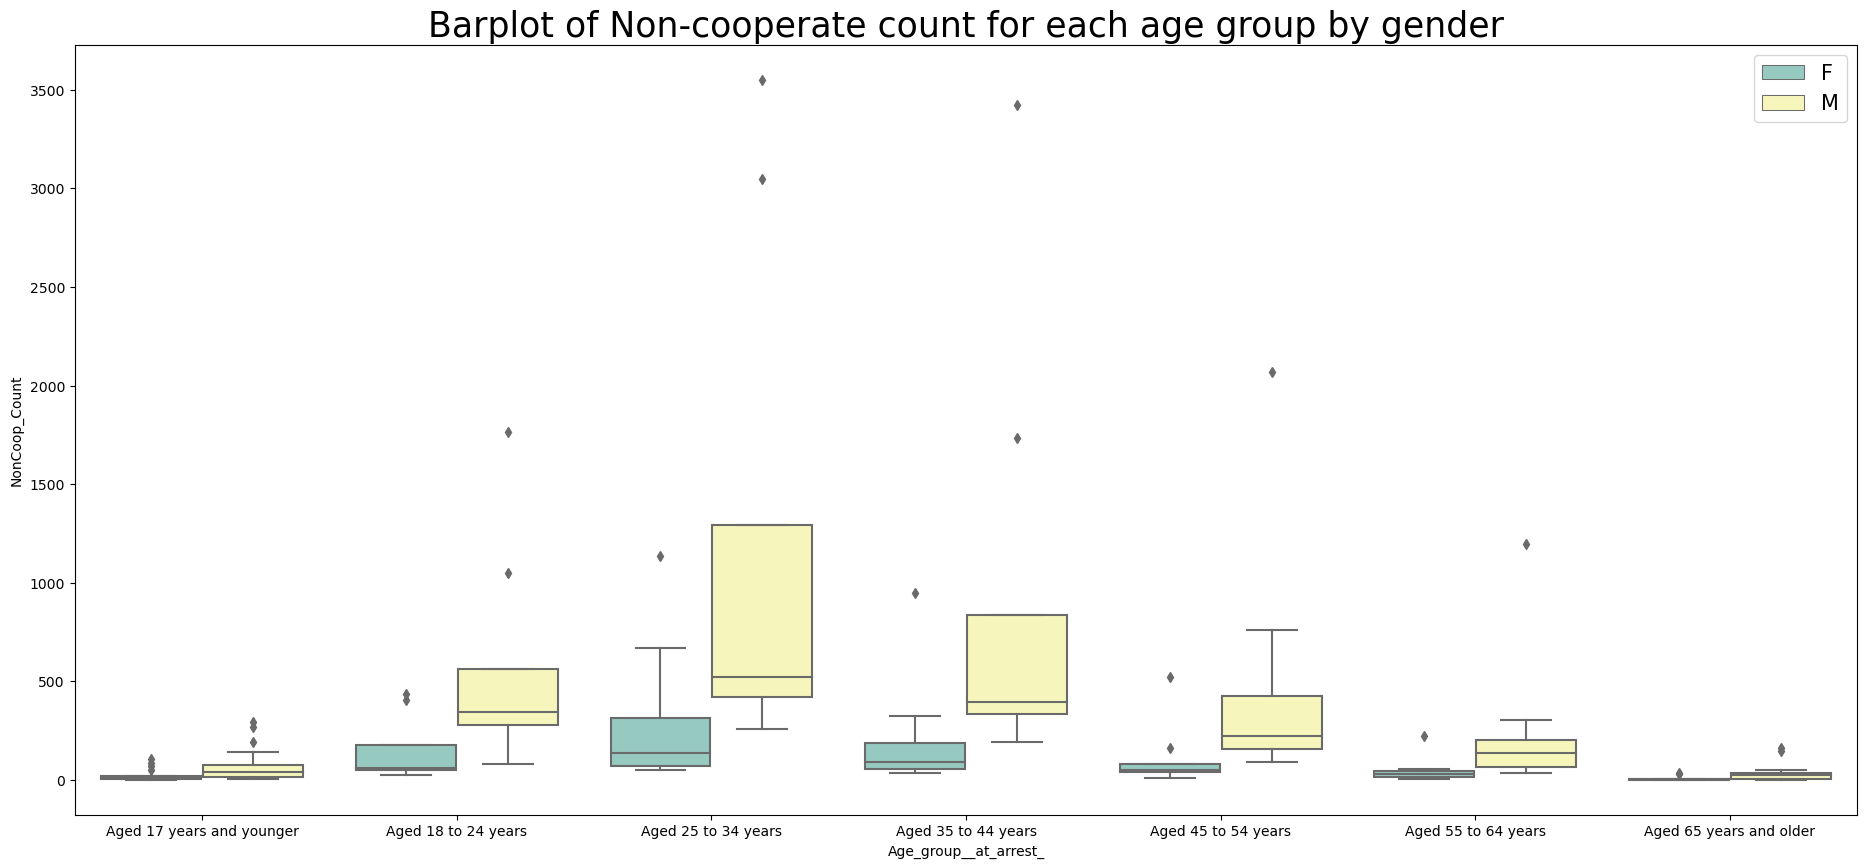

In [27]:
# Boxplot to see the count distribution by age and sex

fig,ax = plt.subplots(figsize=(23,10))
sns.boxplot(x = 'Age_group__at_arrest_', y = 'NonCoop_Count', hue = 'Sex', data = noncoop, palette = 'Set3')
plt.title('Barplot of Non-cooperate count for each age group by gender', fontsize = 25)
plt.legend(fontsize = 15)

In [28]:
# Check 4 assumptions for T-test
# Get the data
noncoop_norm = noncoop.loc[:,'NonCoop_Count']
noncoop_M = noncoop.loc[noncoop['Sex'] == 'M'].loc[:,'NonCoop_Count']
noncoop_F = noncoop.loc[noncoop['Sex'] == 'F'].loc[:,'NonCoop_Count']

# Check Normality(Anderson-Darling Nonrmality Test)
res = anderson(noncoop_norm)
print(res.statistic)
print(res.critical_values)
print(res.significance_level)

res_M = anderson(noncoop_M)
print(res_M.statistic)
print(res_M.critical_values)
print(res_M.significance_level)

res_F = anderson(noncoop_F)
print(res_F.statistic)
print(res_F.critical_values)
print(res_F.significance_level)


# Check homogeneity of variance
print(np.var(noncoop_M),np.var(noncoop_F))
np.var(noncoop_M)/np.var(noncoop_F) <= 4


25.046126593224983
[0.561 0.639 0.766 0.894 1.063]
[15.  10.   5.   2.5  1. ]
11.673317779290059
[0.548 0.624 0.749 0.874 1.039]
[15.  10.   5.   2.5  1. ]
11.66204840603892
[0.547 0.623 0.747 0.871 1.037]
[15.  10.   5.   2.5  1. ]
541220.2561728396 42478.62175605537


False

The test statistic is 25.046. We can compare this value to each critical value that corresponds to each significance level to see if the test result are significant. The critical value for alpha = 0.1 is 1.063. Test result is greater than this critical value, so significant at this level.
\
We can see the test result is significant at every significance level, which means we can reject the null hypothesis. Thus we have sufficient evidence to say that the sample data is not normally distributed.
\
Besides, population variances are not equal.

In [29]:
# One-sided(right tailed) two-sample T-test

# want to check whether people with different sex have the same mean number of noncooperative arrest
# H0: two population means are equal
# Ha: population1 mean is greater than population2 mean

# perform the two sample t-test with equal variances
stats.ttest_ind(a = noncoop_M, b = noncoop_F, alternative = 'greater', equal_var = False)

Ttest_indResult(statistic=3.2643198952849017, pvalue=0.0007984771185654571)

Since P-value(0.0008 is smaller than alpha = 0.05, so we reject the null hypothesis of the test. We have sufficient evidence to say two group means are not equal. 

In [30]:
# Perform two-way ANOVA
noncoop_interactive_model = ols('NonCoop_Count ~ C(Age_group__at_arrest_) + C(Sex) + C(Age_group__at_arrest_):C(Sex)', data = noncoop).fit()
noncoop_interactive_table = sm.stats.anova_lm(noncoop_interactive_model, typ = 2)
noncoop_interactive_table

,sum_sq,df,F,PR(>F)
C(Age_group__at_arrest_),8.729473e+06,6.0,6.083378,0.000013
C(Sex),3.371773e+06,1.0,14.098288,0.000264
C(Age_group__at_arrest_):C(Sex),2.992535e+06,6.0,2.085432,0.059420
Residual,3.013440e+07,126.0,NaN,NaN


Both age and sex are statistically significant. 
\
The p-val of the interation term is greater than alpha = 0.05, we fail to reject the null hypothesis at this level of significance.

In [31]:
# Re-run the two-way ANOVA without the interaction term
noncoop_additive_model = ols('NonCoop_Count ~ C(Age_group__at_arrest_) + C(Sex)', data = noncoop).fit()
noncoop_additive_table = sm.stats.anova_lm(noncoop_additive_model, typ = 2)
print(noncoop_additive_table)

noncoop_residual_sd = sqrt(noncoop_additive_table['sum_sq'][2]/noncoop_additive_table['df'][2])
noncoop_residual_sd

                                sum_sq     df          F    PR(>F)
C(Age_group__at_arrest_)  8.729473e+06    6.0   5.797349  0.000022
C(Sex)                    3.371773e+06    1.0  13.435414  0.000357
Residual                  3.312693e+07  132.0        NaN       NaN


500.9606846979265

In [32]:
# Tukey's HSD Test

# Difference across age groups
noncoop_comp = mc.MultiComparison(noncoop['NonCoop_Count'], noncoop['Age_group__at_arrest_'])
noncoop_age_post_hoc_res = noncoop_comp.tukeyhsd()
noncoop_age_post_hoc_res.summary()

# Extract different levels
noncoop_age_post_hoc_res_summary = pd.DataFrame(noncoop_age_post_hoc_res.summary())
noncoop_age_post_hoc_res_summary.columns = ['Group1','Group2', 'MeanDiff', 'p-adj', '4', '5', 'Reject']
noncoop_age_post_hoc_res_summary['Reject'] =  noncoop_age_post_hoc_res_summary['Reject'].astype('str')
noncoop_age_post_hoc_res_summary
noncoop_differences = noncoop_age_post_hoc_res_summary.loc[noncoop_age_post_hoc_res_summary['Reject'] == 'True', ['Group1','Group2', 'MeanDiff', 'p-adj', 'Reject']]
print(noncoop_differences)
print('Difference exist in the ', len(noncoop_differences), ' out of ', len(noncoop_age_post_hoc_res_summary) - 1, ' comparisons.')
# len(noncoop_differences)
# len(noncoop_age_post_hoc_res_summary)

                       Group1                   Group2   MeanDiff   p-adj  \
2   Aged 17 years and younger      Aged 25 to 34 years      687.5  0.0007   
3   Aged 17 years and younger      Aged 35 to 44 years     513.25  0.0279   
14        Aged 25 to 34 years      Aged 55 to 64 years  -582.0625  0.0329   
15        Aged 25 to 34 years  Aged 65 years and older  -714.1339  0.0005   
18        Aged 35 to 44 years  Aged 65 years and older  -539.8839  0.0214   

   Reject  
2    True  
3    True  
14   True  
15   True  
18   True  
Difference exist in the  5  out of  21  comparisons.


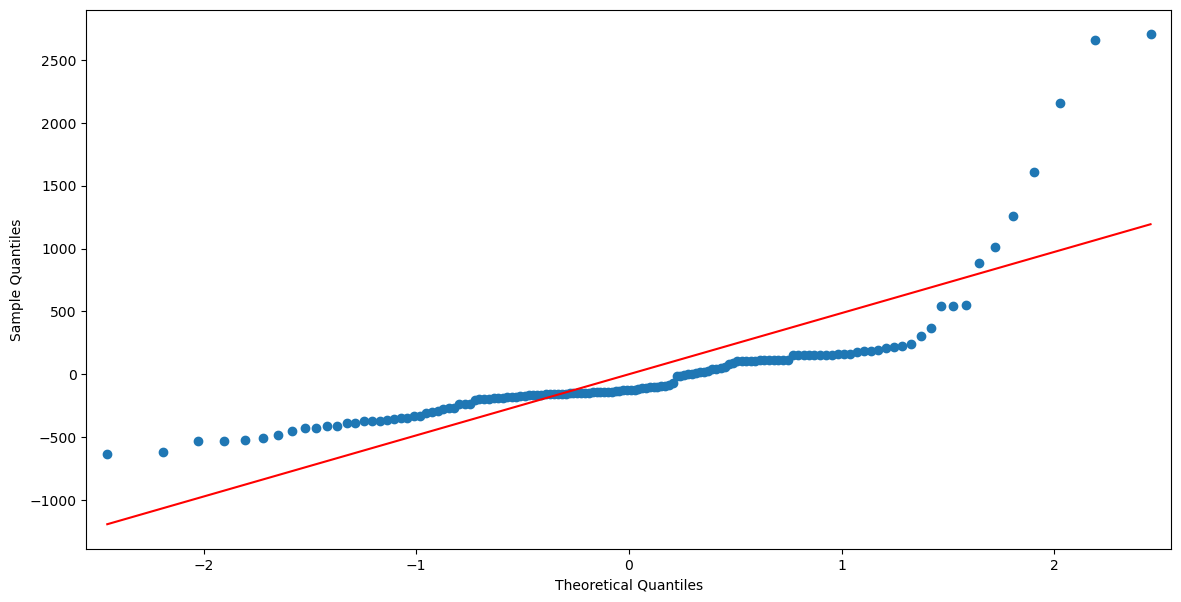

In [33]:
# check for ANOVA assumptions
# QQ-plot(normality)
res_q3 = noncoop_additive_model.resid
fig = sm.qqplot(res_q3, line = 's')
plt.show()

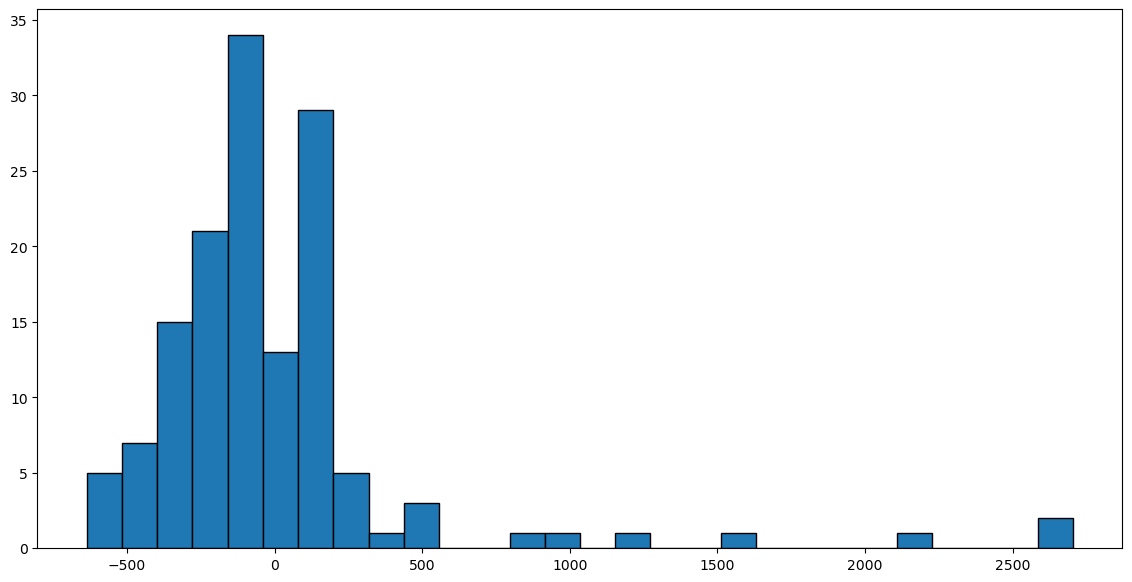

In [34]:
plt.hist(res_q3, bins = 'auto', histtype = 'bar', ec = 'k')
plt.xlabel = ('Residual')
plt.ylabel = ('Frequency')
plt.show()

In [35]:
# homogeneity of variance
# Since dataset is not normal, so we decide to apply Levene's test(Age group)
# H0: samples from populations have equal variance
stats.levene(noncoop[noncoop['Age_group__at_arrest_'] == 'Aged 17 years and younger'].loc[:,'NonCoop_Count'],
             noncoop[noncoop['Age_group__at_arrest_'] == 'Aged 18 to 24 years'].loc[:,'NonCoop_Count'],
             noncoop[noncoop['Age_group__at_arrest_'] == 'Aged 25 to 34 years'].loc[:,'NonCoop_Count'],
             noncoop[noncoop['Age_group__at_arrest_'] == 'Aged 35 to 44 years'].loc[:,'NonCoop_Count'],
             noncoop[noncoop['Age_group__at_arrest_'] == 'Aged 45 to 54 years'].loc[:,'NonCoop_Count'],
             noncoop[noncoop['Age_group__at_arrest_'] == 'Aged 55 to 64 years'].loc[:,'NonCoop_Count'],
             noncoop[noncoop['Age_group__at_arrest_'] == 'Aged 65 years and older'].loc[:,'NonCoop_Count'])

LeveneResult(statistic=4.024271680114501, pvalue=0.0009763307910752297)

LeveneResult (statistic=4.024271680114501, pvalue=0.0009763307910752297)
\
Have sufficient evidence to reject null hypothesis that samples have equal variance.
\
Equal variance assumption is violated.

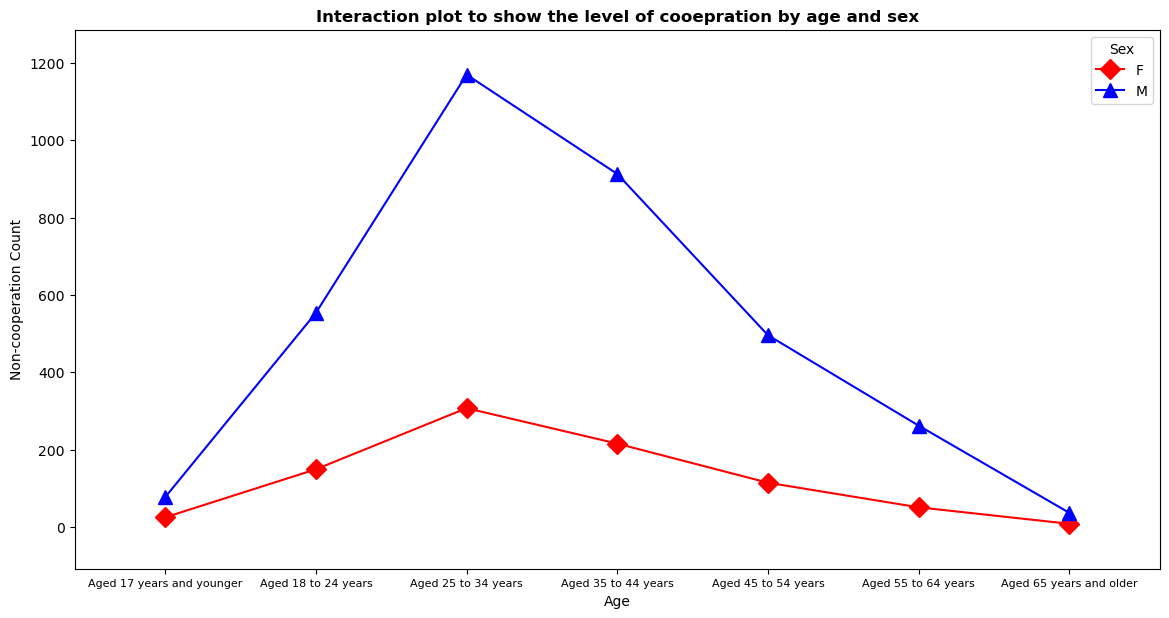

In [36]:
# Interaction plot 

from importlib import reload
plt=reload(plt)

Sex = noncoop['Sex'].astype("category")
Noncoop_Count = noncoop['NonCoop_Count'].values

rq_3_interaction = interaction_plot(noncoop['Age_group__at_arrest_'], Sex, Noncoop_Count, colors=['red','blue'], markers=['D','^'], ms=10)

plt.ylabel('Non-cooperation Count')
plt.xlabel('Age')
plt.title('Interaction plot to show the level of cooepration by age and sex', fontweight='bold')
plt.tick_params(axis='x', which='major', labelsize=8)
plt.show()

